In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
def read_and_decode_mcge_p(path,file):
    with open(os.path.join(path,file), 'r') as f:
        content = f.read()
    number = []
    for s in content.split():
        try:
            x = float(s)
            number.append(x)
        except:
            pass
    content_matrix = np.reshape(number, (8, 5, 8))
    num_proc = content_matrix[0, 0, 2]
    average_time = content_matrix[:,:,3]
    comm_time = content_matrix[:,:,5]
    dist_time = content_matrix[:,:,7]
    return num_proc, average_time, comm_time, dist_time

def read_and_decode_ge_scalapack(path, file):
    with open(os.path.join(path,file), 'r') as f:
        content = f.read()
    content_list = content.split()
    content_2 = content_list[9::9]
    number = []
    for content_2_element in content_2:
        for s in content_2_element.split(','):
            try:
                x = float(s)
                number.append(x)
            except:
                pass
    content_matrix = np.reshape(number, (8, 5, 6))
    average_time = content_matrix[:, :, 5]
    tmp_number = content_list[8].split(',')
    num_proc = int(tmp_number[0])
    return num_proc, average_time



def generate_metrics_mcge_p(path):
    '''
    this function will generate 3x8x8x5 matrices for mc_p and ge_p
    1st dimension: 0-total execution time  1-total communication time 2-data distribution time
    2nd dimension:problem size in thousand (1-8K)
    3rd dimension: number of processors-1 2 4 8 16 32 64 128
    4th dimension: different independent runs'''
    
    #initialize result
    result = np.zeros((3,8,8,5), dtype = float)
    file_list = os.listdir(path)
    for file in file_list:
        num_proc, average_time, comm_time, dist_time = read_and_decode_mcge_p(path,file)
        index = int(np.log2(num_proc))
        result[0, :, index, :] = average_time
        result[1, :, index, :] = comm_time
        result[2, :, index, :] = dist_time
    return result

def generate_metrics_gescalapack(path):
    '''
    This function will generate 8x8x5 matrices for ge_scalapack
    1st dimension:problem size in thousand (1-8K)
    2nd dimension: number of processors-1 2 4 8 16 32 64 128
    3rd dimension: different independent runs'''
    #initialize result
    result = np.zeros((8, 8, 5), dtype = float)
    file_list = os.listdir(path)
    for file in file_list:
        num_proc, average_time = read_and_decode_ge_scalapack(path,file)
        index = int(np.log2(num_proc))
        result[:, index, :] = average_time
    return result

In [4]:
mc_dir = "../output/mc_p"
ge_dir = "../output/ge_p"
gescalapack_dir = "../output/ge_scalapack"
result_mc = generate_metrics_mcge_p(mc_dir)
result_ge = generate_metrics_mcge_p(ge_dir)
result_gescalapack = generate_metrics_gescalapack(gescalapack_dir)

In [5]:
#averaging 5 different runs
result_mc_average = np.mean(result_mc, axis = -1)
result_gep_average = np.mean(result_ge, axis = -1)
result_gescalapack_average = np.mean(result_gescalapack, axis = -1)

In [6]:
#Extract Serial time for all three algorithms (3x 8 matrix)
serial_time = np.array([result_mc_average[0,:,0], result_gep_average[0,:,0], result_gescalapack_average[:,0]])

#calculate the best serial time for the determinant task
best_serial_time = np.min(serial_time, axis= 0)

In [7]:
#calculate the speed up for all algorithms
speedup_mc = np.zeros((8,8), dtype = float)
speedup_ge = np.zeros((8,8), dtype = float)
speedup_gescalapack = np.zeros((8,8), dtype = float)

for i in range(8):
    t_s = best_serial_time[i]
    for j in range(8):
        speedup_mc[i,j] = t_s/ result_mc_average[0, i, j]
        speedup_ge[i,j] = t_s/ result_gep_average[0, i, j]
        speedup_gescalapack[i,j] = t_s/ result_gescalapack_average[i, j]

In [8]:
#calculate the average speedup for all problem size
average_speedup_mc = np.mean(speedup_mc, axis=0)
average_speedup_ge = np.mean(speedup_ge, axis=0)
average_speedup_gescalapack = np.mean(speedup_gescalapack, axis=0)

In [62]:
#calculate the average communication time and data distribution time for mc and ge
average_communication_mc = np.mean(result_mc_average[1, :, :], axis = 0)
average_communication_ge = np.mean(result_gep_average[1, :, :], axis = 0)
average_dist_mc = np.mean(result_mc_average[2, :, :], axis = 0)
average_dist_ge = np.mean(result_gep_average[2, :, :], axis = 0)

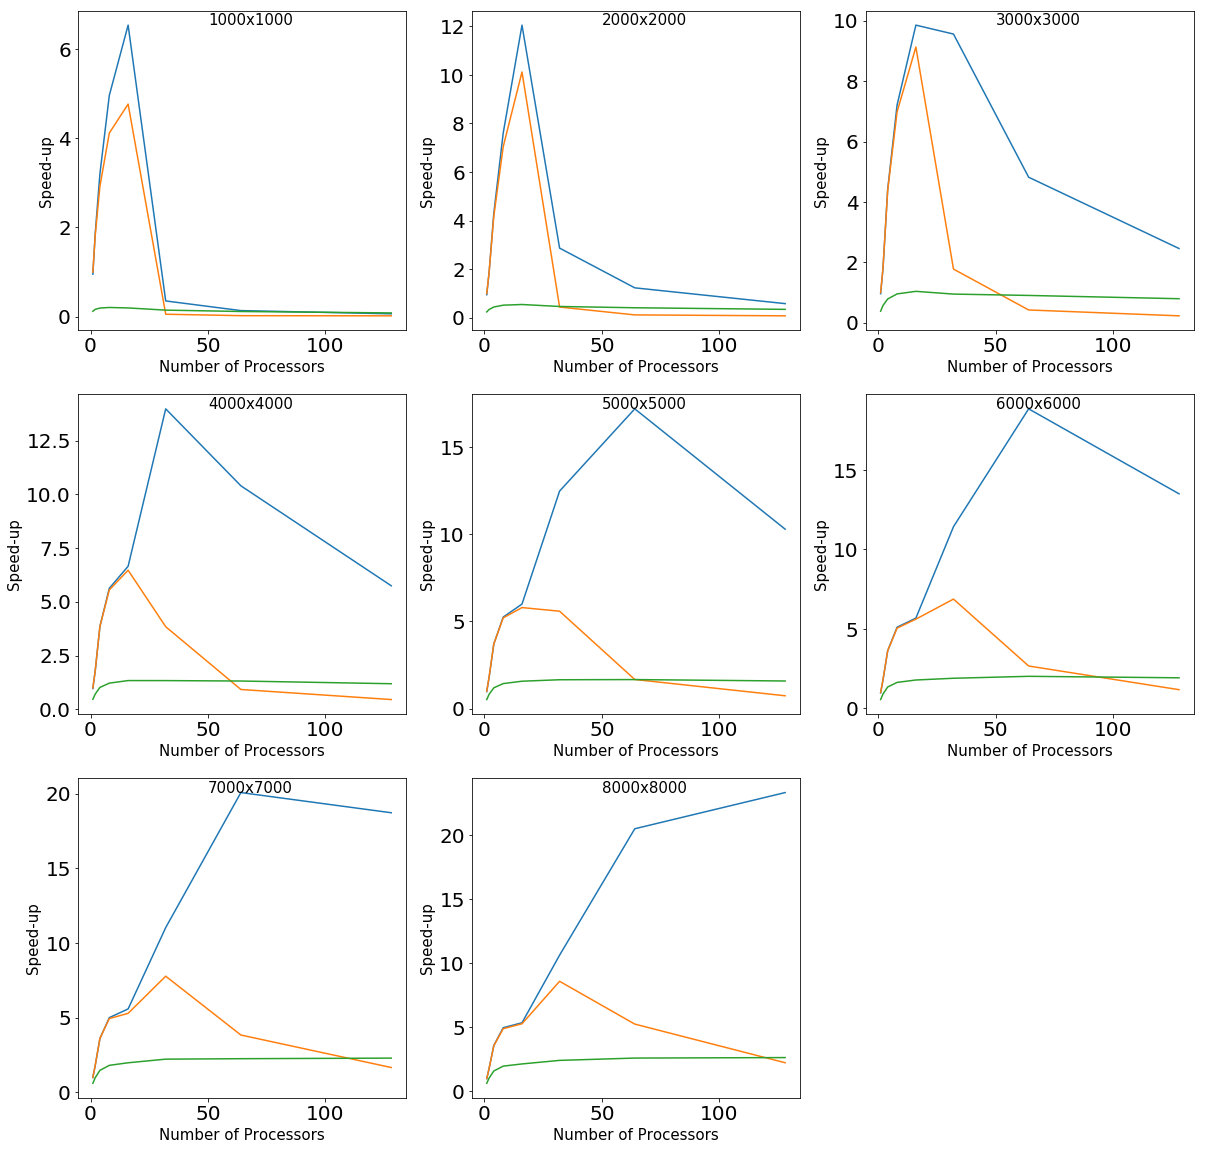

In [56]:
#plot the speedup for all problem size
n_proc = [1, 2, 4, 8, 16, 32, 64, 128]
fig,((ax1, ax2, ax3),(ax4,ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3,figsize=(20,20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(8):
    ax[i].plot(n_proc, speedup_mc[i,:])
    ax[i].plot(n_proc, speedup_ge[i,:])
    ax[i].plot(n_proc, speedup_gescalapack[i,:])
    max_speedup = max(speedup_mc[i,:])
    ax[i].text(50, max_speedup, str((i+1)*1000)+"x" +str((i+1)*1000) ,fontsize = 15)
    ax[i].xaxis.set_tick_params(labelsize = 20)
    ax[i].yaxis.set_tick_params(labelsize = 20)
    ax[i].set_xlabel("Number of Processors",fontsize = 15)
    ax[i].set_ylabel("Speed-up",fontsize = 15)
ax9.axis('off')
plt.show()

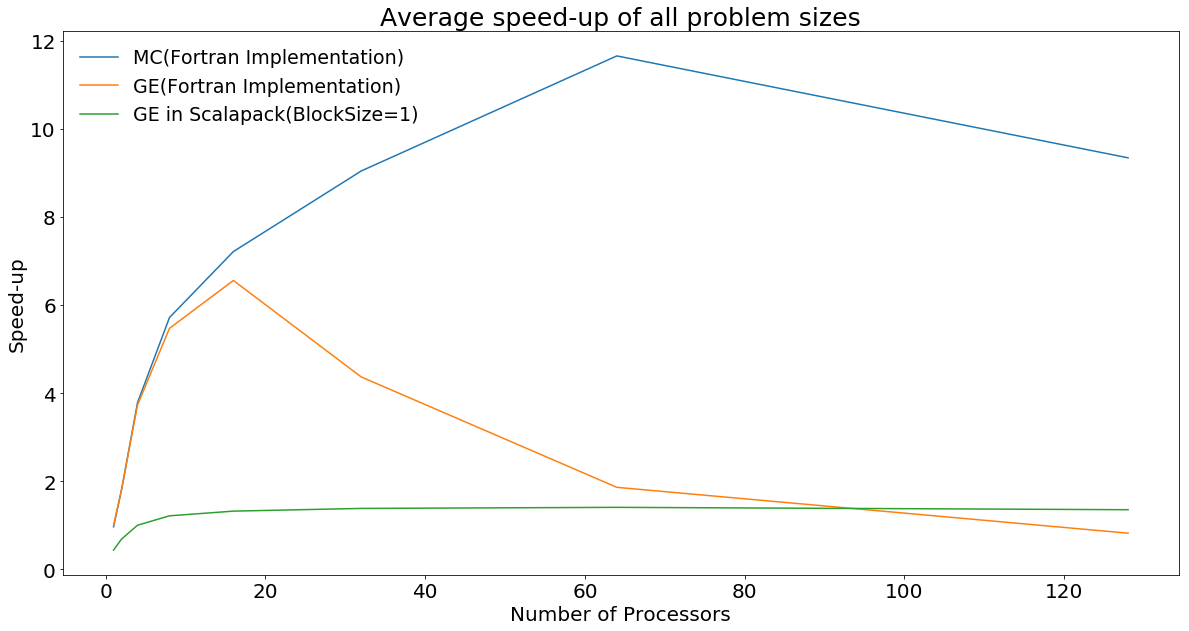

In [38]:
#plot the average speedup
n_proc = [1, 2, 4, 8, 16, 32, 64, 128]
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(n_proc, average_speedup_mc)
ax.plot(n_proc, average_speedup_ge)
ax.plot(n_proc, average_speedup_gescalapack)
ax.set_title("Average speed-up of all problem sizes", fontsize = 25)
ax.set_xlabel("Number of Processors",fontsize = 20)
ax.set_ylabel("Speed-up",fontsize = 20)
ax.legend(["MC(Fortran Implementation)", "GE(Fortran Implementation)", "GE in Scalapack(BlockSize=1)"],loc=2, prop={'size': 19},frameon=False)
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.show()

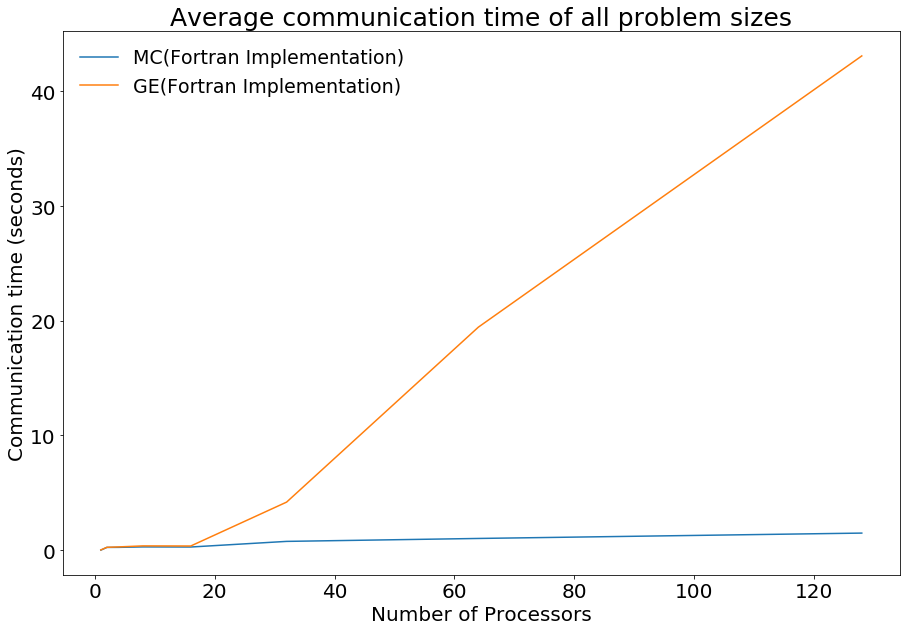

In [60]:
#plot the average communication time
n_proc = [1, 2, 4, 8, 16, 32, 64, 128]
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(n_proc, average_communication_mc)
ax.plot(n_proc, average_communication_ge)
ax.set_title("Average communication time of all problem sizes", fontsize = 25)
ax.set_xlabel("Number of Processors",fontsize = 20)
ax.set_ylabel("Communication time (seconds)",fontsize = 20)
ax.legend(["MC(Fortran Implementation)", "GE(Fortran Implementation)"],loc=2, prop={'size': 19},frameon=False)
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.show()

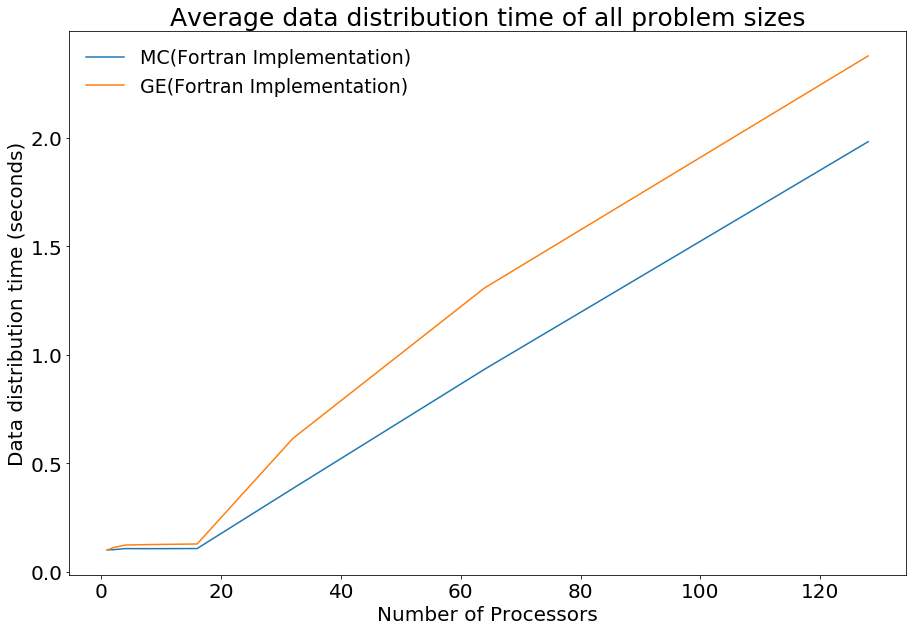

In [63]:
#plot the Data distribution time
n_proc = [1, 2, 4, 8, 16, 32, 64, 128]
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(n_proc, average_dist_mc)
ax.plot(n_proc, average_dist_ge)
ax.set_title("Average data distribution time of all problem sizes", fontsize = 25)
ax.set_xlabel("Number of Processors",fontsize = 20)
ax.set_ylabel("Data distribution time (seconds)",fontsize = 20)
ax.legend(["MC(Fortran Implementation)", "GE(Fortran Implementation)"],loc=2, prop={'size': 19},frameon=False)
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.show()